Mean Squared Error: 89.1137444845745
Root Mean Squared Error: 9.440007652781564
R-squared Error: 0.9854625275821002


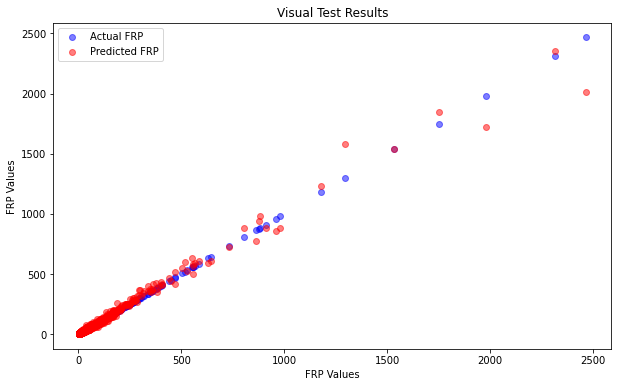

0        0
1        0
2        0
3        0
4        0
        ..
22248    0
22249    0
22250    0
22251    0
22252    0
Name: bug_class, Length: 22253, dtype: int32


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit,GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import boto3
from botocore.exceptions import ClientError
import time



class Modis:
    
    def __init__(self, data_file):
        self.df = pd.read_csv(data_file)
        #self.df = self.preprocess_data()

    #SELF HEALING DATA    
    def preprocess_data(self):
        # Drop unnecessary columns
        self.df = self.df.drop(['track', 'instrument', 'version'], axis=1)

        # Map categorical variables to numeric values
        self.df['satellite'] = self.df['satellite'].map({'Terra': 0, 'Aqua': 1})
        self.df['daynight'] = self.df['daynight'].map({'D': 0, 'N': 1})

        # Create month column
        self.df['month'] = pd.to_datetime(self.df['acq_date']).dt.month

        # Sample data to reduce computation time
        self.df = self.df.sample(frac=0.2, random_state=42)
        self.df = self.df.reset_index(drop=True)

        # Drop rows with missing values
        self.df.dropna(inplace=True)

        return self.df

     #TEST DATA GENERATION
    def train_test_split(self):
        # Split data into train and test sets
        X = self.df[['latitude', 'longitude', 'month', 'brightness', 'scan', 'acq_time', 'bright_t31', 'daynight']]
        y = self.df['frp']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Scale the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test

    def model_training(self, X_train_scaled, y_train):
        # Hyperparameter tuning for Random Forest
        rf_param_grid = {
            'n_estimators': [100, 200, 500],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split': [2, 4, 8]
        }
        rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, n_jobs=-1)
        rf_grid.fit(X_train_scaled, y_train)

        # Hyperparameter tuning for Gradient Boosting
        gb_param_grid = {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [3, 5, 7]
        }
        gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=5, n_jobs=-1)
        gb_grid.fit(X_train_scaled, y_train)

        # Hyperparameter tuning for XGBoost
        xgb_param_grid = {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [3, 5, 7]}
        xgb_grid = GridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, cv=5, n_jobs=-1)
        xgb_grid.fit(X_train_scaled, y_train)

        # Train the models with the best hyperparameters
        estimators = [
            ('rf', rf_grid.best_estimator_),
            ('gb', gb_grid.best_estimator_),
            ('xgb', xgb_grid.best_estimator_)
        ]

        stacking_regressor = StackingRegressor(
            estimators=estimators,
            final_estimator=LinearRegression()
        )

        stacking_regressor.fit(X_train_scaled, y_train)

        return stacking_regressor
    
    #TEST DATA GENERATION
    def ensemble_predictions(self, stacking_regressor, X_test_scaled):
        # Make ensemble predictions
        ensemble_predictions = stacking_regressor.predict(X_test_scaled)       

        return ensemble_predictions
    
   #VISUAL NON VISUAL TEST VALIDATION
    def evaluation(self, y_test, ensemble_predictions):
    # Evaluate the model
        mse = mean_squared_error(y_test, ensemble_predictions)
        rmse = np.sqrt(mse)
        r_squared = r2_score(y_test, ensemble_predictions)
        print("Mean Squared Error:", mse)
        print("Root Mean Squared Error:", rmse)
        print("R-squared Error:", r_squared)
         # Visual test validation
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_test, c='blue', alpha=0.5, label='Actual FRP')
        plt.scatter(y_test, ensemble_predictions, c='red', alpha=0.5, label='Predicted FRP')
        plt.xlabel("FRP Values")
        plt.ylabel("FRP Values")
        plt.title("Visual Test Results")
        plt.legend(loc='upper left')
        plt.show()
        
     #BUG CLASSIFICATION  
    def bug_classification(self, threshold=2000):
        # Classify data as "buggy" or "not buggy" based on FRP threshold
        self.df['bug_class'] = np.where(self.df['frp'] > threshold, 1, 0)

        return self.df
    
    def check_for_new_data_locally(self, time_limit_hours=24):
        #check for new data locally every hour 
        start_time = time.time()
        while time.time() - start_time < time_limit_hours * 3600:
            # Check for new data here
            new_data = pd.read_csv('new_data.csv')
            if not new_data.empty:
                self.df = pd.concat([self.df, new_data], axis=0)
                self.df = self.preprocess_data()

            time.sleep(3600) # Check every hour

       

    def check_for_new_data_from_s3(self, time_limit_hours=24):
         #check for new data from a s3 bucket every hour 
        start_time = time.time()
        while time.time() - start_time < time_limit_hours * 3600:
            # Check for new data here
            try:
                s3 = boto3.client('s3')
                obj = s3.get_object(Bucket='bucket-name', Key='new_data.csv')
                new_data = pd.read_csv(obj['Body'])
                if not new_data.empty:
                    self.df = pd.concat([self.df, new_data], axis=0)
                    self.df = self.preprocess_data()
            except ClientError as e:
                if e.response['Error']['Code'] == 'NoSuchKey':
                    print('The object does not exist.')
                else:
                    print('An error occurred while trying to read data from the S3 bucket.')

            time.sleep(3600) # Check every hour
            
  
# Create an instance of the Modis class
modis = Modis("modis_2021_India.csv")

# Preprocess the data
modis.preprocess_data()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = modis.train_test_split()

# Train the models
stacking_regressor = modis.model_training(X_train, y_train)

# Make ensemble predictions
ensemble_predictions =modis.ensemble_predictions(stacking_regressor, X_test)

# Evaluate the model
modis.evaluation(y_test, ensemble_predictions)
# Call bug_classification function with default threshold of 2000
modis.bug_classification()

# Access the "bug_class" column in the dataframe to see the bug classification
print(modis.df['bug_class'])